# 02: Interpretable Model

Our goals for this notebook:
1. Build a logistic regression model.
    * In order to have interpretability for the symptoms, we'll build a logistic regression model that will provide log-odds betas for each feature allowing us to analyze each feature's individual influence on the odds of a COVID-19 test being positive.
2. Attempt to improve our model through oversampling and undersampling strategies to correct for the imbalance in our target variable.
    * Special thanks to Jason Brownlee and his posts ['Cost-Sensitive Logistic Regression for Imbalanced Classification'](https://machinelearningmastery.com/cost-sensitive-logistic-regression/) and ['Random Oversampling and Undersampling for Imbalanced Classification'](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/).

**Please note:** We will evaluate the fit of our model based on the true positive rate (also called recall or sensitivity). This metric measures our ability to maximize classifying actual positive tests correctly as we seek to minimize the number of actual positive tests that our model incorrectly classifies as negative tests.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report

import statsmodels.api as sm

# set a random seed
np.random.seed(42)

## Model A: Patient Reported Symptom Features Only

### Load Data

We'll start by loading the data file for patient symptoms that we cleaned in our first notebook.

In [2]:
patient = pd.read_csv('../data/cleaned_data/patient_symptoms.csv')

In [3]:
patient.head()

,onset,cough_comb,fever,sob_comb,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,covid19_test_results
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,1,1,0,0,0,0,0,0


In [4]:
patient.shape

(93785, 13)

Everything is as expected.

### Base Logistic Regression

Before we begin, let's take a look at the accuracy and recall scores for a base logistic regression to see how it handles our imbalanced classes.

In [5]:
# set up X and y
X = patient.drop(columns='covid19_test_results')
y = patient['covid19_test_results']

In [6]:
# baseline
y.value_counts(normalize=True)

0    0.986053
1    0.013947
Name: covid19_test_results, dtype: float64

In [7]:
# instantiate model
logreg = LogisticRegression(penalty='none')

# stratified cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state = 42)

print(f'Mean cross-val accuracy score: {cross_val_score(estimator=logreg, scoring="accuracy", X=X, y=y, cv=cv).mean()}')
print(f'Mean cross-val recall score: {cross_val_score(estimator=logreg, scoring="recall", X=X, y=y, cv=cv).mean()}')

Mean cross-val accuracy score: 0.9859394756149747
Mean cross-val recall score: 0.023466431787042476


The baseline results for the logistic regression (with no penalty) from the three repeats of a stratified 10-fold cross-validation are as expected: accuracy matches the baseline, but our ability to predict the true positive rate is very low due to the imbalance in our classes (only 2.3% of all positive tests are classified correctly).

### Weighted Logistic Regression (using `class_weight = 'balanced'`)

There is a built-in parameter in logistic regression that will allow us to apply the generalized best practice of using applying class weighting to each class that is the inverse of it's distribution in our dataset. Let's see how setting the autobalancing via the `class_weight` parameter affects our recall and accuracy scores using cross-validation.

In [8]:
# instantiate model specifing balanced class weights
logreg = LogisticRegression(penalty='none', class_weight='balanced')

# stratified cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state = 42)

print(f'Mean cross-val accuracy score: {cross_val_score(estimator=logreg, scoring="accuracy", X=X, y=y, cv=cv).mean()}')
print(f'Mean cross-val recall score: {cross_val_score(estimator=logreg, scoring="recall", X=X, y=y, cv=cv).mean()}')

Mean cross-val accuracy score: 0.8715074908481216
Mean cross-val recall score: 0.5213994910941476


By balancing the classes, our accuracy has decreased, but our recall score has improved markedly from only being able to  . This 

We could grid search through weights, but let's see what random oversampling and undersampling can perform. 

### Random Oversampling and Undersampling

To help correct our imbalanced classes, we've imported the imbalanced-learn library. This will give us access to the RandomOverSampler and RandomUnderSampler that will allow to test various strategies of bootstrapping our training data by replicating or dropping random rows to aid us in fitting the best model possible based on recall score.

In order to create a pipeline for our grid search, we'll utilize imbalanced-learn's Pipeline rather than scikit-learn. The reason for this is that with this pipeline the over- and undersampling that will applied when fitting the model to training data will not be applied when predicting on test data. 

In [9]:
# train / test / split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.4, stratify=y)

In [10]:
np.random.seed(42)

# pipeline with oversampling, undersampling, and our logistic regression
pipe = Pipeline([
    ('over', RandomOverSampler()), # random sampling with replacement of the minority class
    ('under', RandomUnderSampler()), # random sampling of majority class to match ratio
    ('logreg', LogisticRegression())
])

# parameters to grid search over for the steps in our pipeline
pipe_params = {
    'logreg__penalty': ['none'], # no regularization will be applied
    'logreg__solver': ['newton-cg', 'lbfgs'],
    'over__sampling_strategy': np.linspace(0.1, 0.4, 4), # values are the ratio of minority class / majority class
    'under__sampling_strategy': [0.5, 0.75, 1.0] # values are the ratio of minority class / majority class
}

# stratified cross-validation with 10 folds repeated 3 times
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state = 42)

# grid search optimizing for recall score
gs = GridSearchCV(estimator=pipe, param_grid=pipe_params, scoring='recall', cv=cv)

# fitting model
gs.fit(X_train, y_train)

# output params and scores of best model
print(f'Best params: {gs.best_params_}')
print(f'Best score (recall): {gs.best_score_}')
print(f'Train accuracy score: {accuracy_score(y_train, gs.predict(X_train))}')
print(f'Test accuracy score: {accuracy_score(y_test, gs.predict(X_test))}')
print(f'Train recall score: {gs.score(X_train, y_train)}')
print(f'Test recall score: {gs.score(X_test, y_test)}')

Best params: {'logreg__penalty': 'none', 'logreg__solver': 'newton-cg', 'over__sampling_strategy': 0.30000000000000004, 'under__sampling_strategy': 1.0}
Best score (recall): 0.5176566049983772
Train accuracy score: 0.8679781770361288
Test accuracy score: 0.86751612731247
Train recall score: 0.5261146496815287
Test recall score: 0.5372848948374761


The model resulting from our grid search has recall scores for training and testing data around 53%, not much of difference from our cross-val testing score for the logistic regression model with balanced weighting. With the limitations of our data (lack of testing data for patients with sever symptoms / the imbalanced classes), we likely won't improve on this recall score without additional data.

In order to analyze the data we do have, we'll build a logistic regression model from statemodels using the best parameters from our grid search. The statsmodels version of logistic regression will give access to the betas and p-values.

To summarize our best parameters from the grid search, we'll be building a logistic regression model with:
* no penalty attached
* using the newton-cg solver
* with an oversampling strategy of 0.3
    * the minority class will be randomly sampled with replacement until its number of observations are 30% of the number of observations in the majority class.
* with an undersampling strategy of 1.0
    * the majority class will randomly drop observations until the number of observations in the minority and majority class are the same.
    
In regards to this over- and undersampling:
* We have randomly duplicated our minority class observations growing it to almost 30x its regular size. Depending on the quality of the data and the vagaries of random sample, we may have replicated erroneous or misleading observations along with useful ones. 
* We are potentially losing a lot of valuable data by dropping this many observations (nearly 64k) from the majority class as we match it to the level of our augmented minority class.

### StatsModels Logistic Regression

Now to build our the statsmodels logistic regression.

In [11]:
np.random.seed(42)

# set oversampling strategy
over = RandomOverSampler(sampling_strategy=0.3)
X_resamp, y_resamp = over.fit_resample(X_train, y_train)

# set undersampling strategy
under = RandomUnderSampler(sampling_strategy=1.0)
X_resamp, y_resamp = under.fit_resample(X_resamp, y_resamp)

# adding required constant in training and test data
X_resamp = sm.add_constant(X_resamp)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# instantiate and fit model
sm_logreg = sm.Logit(y_resamp, X_resamp).fit(method='ncg') # fitting with the newton-cg solver

Optimization terminated successfully.
         Current function value: 0.578427
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Hessian evaluations: 8


In [12]:
sm_logreg.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:              Logit                Pseudo R-squared: 0.166     
Dependent Variable: covid19_test_results AIC:              38537.6766
Date:               2020-12-23 06:47     BIC:              38647.0457
No. Observations:   33290                Log-Likelihood:   -19256.   
Df Model:           12                   LL-Null:          -23075.   
Df Residuals:       33277                LLR p-value:      0.0000    
Converged:          1.0000               Scale:            1.0000    
----------------------------------------------------------------------
                  Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
----------------------------------------------------------------------
const            -0.6123    0.0143  -42.9649  0.0000  -0.6403  -0.5844
onset             0.3115    0.0157   19.8044  0.0000   0.2807   0.3424
cough_comb        0.4846    0.0205   23.6300  0.0000   0.4444   0.5248
fever             1.2882    0.0673   19.1442  0.0000   1.1563   1.4201
sob_comb         -0.2802    0.0273  -10.2601  0.0000  -0.3337  -0.2267
diarrhea         -0.5043    0.0806   -6.2592  0.0000  -0.6623  -0.3464
fatigue          -0.4101    0.0537   -7.6312  0.0000  -0.5154  -0.3048
headache          0.5280    0.0508   10.4029  0.0000   0.4285   0.6274
loss_of_smell     2.0843    0.1269   16.4267  0.0000   1.8356   2.3330
loss_of_taste     1.3014    0.1193   10.9116  0.0000   1.0676   1.5351
runny_nose        0.0498    0.0596    0.8361  0.4031  -0.0670   0.1667
muscle_sore       0.8070    0.0597   13.5234  0.0000   0.6900   0.9240
sore_throat      -0.2574    0.0504   -5.1023  0.0000  -0.3562  -0.1585
=====================================================================

"""

Looking at the p-values for the betas (coefficients) of patient symptoms, all except for `runny_nose` are below our alpha of 0.01 and therefore are statistically meaningful at the 99% confidence level. These betas represent log-odds: we'll examine them further in a moment. 

Let's check our recall score on the training and testing data.

In [13]:
# create predictions for training and testing data
train_preds = (sm_logreg.predict(X_train) > 0.5).astype('int32')
test_preds = (sm_logreg.predict(X_test) > 0.5).astype('int32')

# recall scores
print(f'Training Recall Score: {recall_score(y_train, train_preds)}')
print(f'Testing Recall Score: {recall_score(y_test, test_preds)}')

Training Recall Score: 0.5248407643312102
Testing Recall Score: 0.5353728489483748


These are close to the model built in scikit-learn and vary slightly due to the variation slightly implementation differences between the two libraries.

Let's plot a confusion matrix to visualize the differences between what our model predicted and the actual values. We'll follow that with a classification report. 

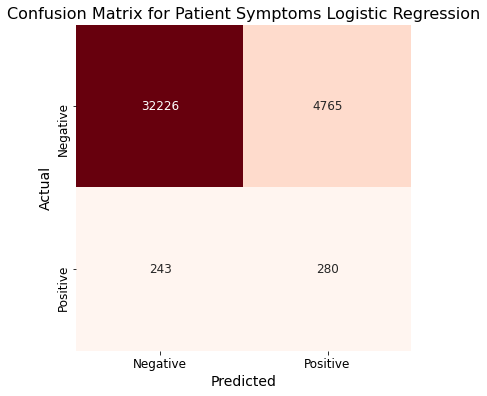

In [14]:
# confusion matrix graphed as an sns heatmap
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_test, test_preds), cmap='Reds', annot=True, fmt='g',
            yticklabels=['Negative', 'Positive'], xticklabels=['Negative', 'Positive'], 
            cbar=False, annot_kws={"size": 12})
plt.xlabel('Predicted', size=14)
plt.xticks(size=12)
plt.ylabel('Actual', size=14)
plt.yticks(size=12)
plt.title('Confusion Matrix for Patient Symptoms Logistic Regression', size = 16);

In [15]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93     36991
           1       0.06      0.54      0.10       523

    accuracy                           0.87     37514
   macro avg       0.52      0.70      0.51     37514
weighted avg       0.98      0.87      0.92     37514



As we've seen previously, the oversampling/undersampling helped our model improve its recall score for the true positives in our testing data but only to ~54%. The confusion matrix  clearly shows the values behind our recall score with 243 False Negatives and 280 True Positives. The class imbalance is also very clear with the actual negative observation number in the top row greatly exceeding the actual positive observations in our bottom row.

Let's take a look a the symptom feature betas for our model and how they can be interpreted.

In [16]:
# dataframe to hold summary of betas, p-values, exponentiated betas -- index = feature names
exp_patient_symptom_betas = pd.DataFrame(index=sm_logreg.params.index)

# beta values from model
exp_patient_symptom_betas['betas'] = round(sm_logreg.params, 3)

# p-values from model
exp_patient_symptom_betas['pvals'] = round(sm_logreg.pvalues, 3)

# exponentiated of betas
exp_patient_symptom_betas['exp_betas'] = round(np.exp(exp_patient_symptom_betas['betas']),3)

# dropping the intercept
exp_patient_symptom_betas.drop(index='const', axis=0, inplace=True)

# showing only features with p-values < 0.01, sorted in descending order by exponentiated betas
exp_patient_symptom_betas.loc[exp_patient_symptom_betas['pvals'] < 0.01, :].sort_values(by='exp_betas', ascending=False)

,betas,pvals,exp_betas
loss_of_smell,2.084,0.0,8.037
loss_of_taste,1.301,0.0,3.673
fever,1.288,0.0,3.626
muscle_sore,0.807,0.0,2.241
headache,0.528,0.0,1.696
cough_comb,0.485,0.0,1.624
onset,0.312,0.0,1.366
sore_throat,-0.257,0.0,0.773
sob_comb,-0.280,0.0,0.756
fatigue,-0.410,0.0,0.664


The above dataframe shows all features with a p-value < 0.01 along with their betas (as log-odds) and their exponentiated values. Let's interpret the first three features:

* If a patient reports the symptom loss of smell, the patient is 8.037 times as likely to test positive for COVID-19, all else being held constant. 
* If a patient reports the symptom loss of taste, the patient is 3.673 times as likely to test positive for COVID-19, all else being held constant. 
* If a patient reports the symptom fever, the patient is 3.626 times as likely to test positive for COVID-19, all else being held constant. 

Please note that the interpretations are based on a 1 unit increase in the feature. Most of these cases are binary, so simply reflect patient reporting whether or not they have the symptom. Some features were adjusted to ordinal values in cleaning (`cough_comb`, `onset`, and `sob_comb`), so please reference cleaning to accurately apply the 1 unit increase for these features.

---

## Model B: Patient Symptoms and Clinically Collected Vitals

We'll follow the same process as we did in the last section, and look at our cleaned dataset patients with both self-reported and  clinically collected vitals features.

### Load Data

In [17]:
clinic_patient = pd.read_csv('../data/cleaned_data/clinical_patient_comb.csv')

In [18]:
clinic_patient.head()

,temperature,pulse,sys,dia,rr,sats,diarrhea,fatigue,headache,loss_of_smell,...,onset,ctab_False,ctab_True,labored_respiration_False,labored_respiration_True,rhonchi_False,rhonchi_True,wheezes_False,wheezes_True,covid19_test_results
0,37.00,74.0,123.0,80.0,17.0,99.0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,0
1,36.75,88.0,105.0,73.0,12.0,96.0,0,0,0,0,...,0,0,1,1,0,0,1,0,1,0
2,36.95,83.0,138.0,61.0,18.0,99.0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,36.85,88.0,160.0,99.0,12.0,99.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,37.00,82.0,111.0,74.0,17.0,99.0,0,1,1,0,...,2,1,0,0,0,0,0,1,0,0


In [19]:
clinic_patient.shape

(39916, 26)

Data pulled in successfully. The cleaned data is less than half the size of our previous dataset with only patient reported symptoms.

Let's set up X and y and get a baseline for how our unbalanced classes look in this data set.

In [20]:
# set up X and y
X2 = clinic_patient.drop(columns='covid19_test_results')
y2 = clinic_patient['covid19_test_results']

In [21]:
# baseline
y2.value_counts(normalize=True)

0    0.976501
1    0.023499
Name: covid19_test_results, dtype: float64

The extreme imbalance between the two classes is apparent in this dataset.

Let's train/test/split our data and run it through our gridsearch along with over/undersampling.

In [22]:
# train / test / split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42, test_size=0.4, stratify=y2)

In [23]:
np.random.seed(42)

pipe = Pipeline([
    ('over', RandomOverSampler()), # random sampling with replacement of the minority class
    ('under', RandomUnderSampler()), # random sampling of majority class to match ratio
    ('logreg', LogisticRegression())
])


"""Please note: other parameters were searched, but some resulted in convergence errors.
For the purpose of this notebook, I have simplified the grid search parameters"""
# parameters to grid search over for the steps in our pipeline
pipe_params = {
    'logreg__penalty': ['none'], # no regularization will be applied
    'logreg__solver': ['newton-cg'],
    'over__sampling_strategy': [0.2, 0.5], # values are the ratio of minority class / majority class
    'under__sampling_strategy': [1.0] # values are the ratio of minority class / majority class
}

# stratified cross-validation with 10 folds repeated 3 times
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state = 42)

# grid search optimizing for recall score
gs = GridSearchCV(estimator=pipe, param_grid=pipe_params, scoring='recall', cv=cv)

# fitting the model
gs.fit(X2_train, y2_train)

# output params and scores of best model
print(f'Best params: {gs.best_params_}')
print(f'Best score (recall): {gs.best_score_}')
print(f'Train accuracy score: {accuracy_score(y2_train, gs.predict(X2_train))}')
print(f'Test accuracy score: {accuracy_score(y2_test, gs.predict(X2_test))}')
print(f'Train recall score: {gs.score(X2_train, y2_train)}')
print(f'Test recall score: {gs.score(X2_test, y2_test)}')

Best params: {'logreg__penalty': 'none', 'logreg__solver': 'newton-cg', 'over__sampling_strategy': 0.5, 'under__sampling_strategy': 1.0}
Best score (recall): 0.5837928153717628
Train accuracy score: 0.7845421520731555
Test accuracy score: 0.7918832592221456
Train recall score: 0.5950266429840142
Test recall score: 0.552


We have a slightly better recall score with this new dataset, but our accuracy has dropped.

Let's fit our statsmodels logistic regression with the results from our grid search. The same caveats hold true from our earlier look at over/undersampling.

In [24]:
np.random.seed(42)

# set oversampling strategy
over2 = RandomOverSampler(sampling_strategy=0.5)
X2_resamp, y2_resamp = over.fit_resample(X2_train, y2_train)

# set undersampling strategy
under2 = RandomUnderSampler(sampling_strategy=1.0)
X2_resamp, y2_resamp = under.fit_resample(X2_resamp, y2_resamp)

# adding required constant in training and test data
X2_resamp = sm.add_constant(X2_resamp)
X2_train = sm.add_constant(X2_train)
X2_test = sm.add_constant(X2_test)

# instantiate and fit model
sm_logreg2 = sm.Logit(y2_resamp, X2_resamp).fit(method='ncg')

Optimization terminated successfully.
         Current function value: 0.622896
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
         Hessian evaluations: 4


In [25]:
sm_logreg2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
=========================================================================
Model:                Logit                 Pseudo R-squared:  0.101     
Dependent Variable:   covid19_test_results  AIC:               17530.4669
Date:                 2020-12-23 06:47      BIC:               17726.7396
No. Observations:     14030                 Log-Likelihood:    -8739.2   
Df Model:             25                    LL-Null:           -9724.9   
Df Residuals:         14004                 LLR p-value:       0.0000    
Converged:            1.0000                Scale:             1.0000    
-------------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
const                     -0.0011   2.5771 -0.0004 0.9997 -5.0521  5.0499
temperature                0.0212   0.0591  0.3593 0.7194 -0.0945  0.1370
pulse                      0.0185   0.0015 12.6231 0.0000  0.0156  0.0214
sys                        0.0065   0.0018  3.7145 0.0002  0.0031  0.0100
dia                        0.0061   0.0030  2.0517 0.0402  0.0003  0.0120
rr                         0.1079   0.0096 11.2152 0.0000  0.0890  0.1267
sats                      -0.0572   0.0136 -4.1877 0.0000 -0.0839 -0.0304
diarrhea                   0.0125   0.1026  0.1215 0.9033 -0.1886  0.2135
fatigue                    0.0236   0.0692  0.3415 0.7327 -0.1120  0.1593
headache                   0.0810   0.0653  1.2408 0.2147 -0.0469  0.2089
loss_of_smell              0.0622   0.1104  0.5635 0.5731 -0.1542  0.2787
loss_of_taste              0.0563   0.1130  0.4980 0.6185 -0.1652  0.2778
runny_nose                 0.0238   0.0733  0.3242 0.7458 -0.1200  0.1675
muscle_sore                0.0704   0.0713  0.9880 0.3231 -0.0693  0.2101
sore_throat                0.0512   0.0607  0.8436 0.3989 -0.0678  0.1702
cough_comb                 0.2720   0.0241 11.2657 0.0000  0.2247  0.3194
sob_comb                   0.0082   0.0356  0.2305 0.8177 -0.0616  0.0780
onset                      0.3238   0.0203 15.9729 0.0000  0.2841  0.3636
ctab_False                 0.0569   0.0625  0.9107 0.3624 -0.0656  0.1794
ctab_True                 -0.0295   0.0804 -0.3670 0.7136 -0.1871  0.1281
labored_respiration_False -0.0231   0.0761 -0.3034 0.7616 -0.1723  0.1261
labored_respiration_True   0.0035   0.3216  0.0109 0.9913 -0.6268  0.6338
rhonchi_False              0.0447   0.1084  0.4123 0.6801 -0.1677  0.2571
rhonchi_True              -0.0408   0.0934 -0.4370 0.6621 -0.2240  0.1423
wheezes_False              0.0496   0.1060  0.4675 0.6402 -0.1582  0.2574
wheezes_True              -0.0510   0.1027 -0.4960 0.6199 -0.2523  0.1504
=========================================================================

"""

Looking at the p-values for the betas (coefficients) of combined patient symptoms and clinical features, there are six features with values are below our alpha of 0.01 and therefore are statistically meaningful at the 99% confidence level. We'll take a look at them in a moment.

Let's check our recall score on the training and testing data.

In [26]:
# create predictions for training and testing data
train_preds2 = (sm_logreg2.predict(X2_train) > 0.5).astype('int32')
test_preds2 = (sm_logreg2.predict(X2_test) > 0.5).astype('int32')

# recall scores
print(f'Training Recall Score: {recall_score(y2_train, train_preds2)}')
print(f'Testing Recall Score: {recall_score(y2_test, test_preds2)}')

Training Recall Score: 0.6127886323268206
Testing Recall Score: 0.5893333333333334


The recall scores are higher the model in our grid search. Although the same random seed was set for the instance, variations in how the data was processed by the two different versions of this model are possible.

Let's plot a confusion matrix to visualize the differences between what our model predicted and the actual values. We'll follow that with a classification report. 

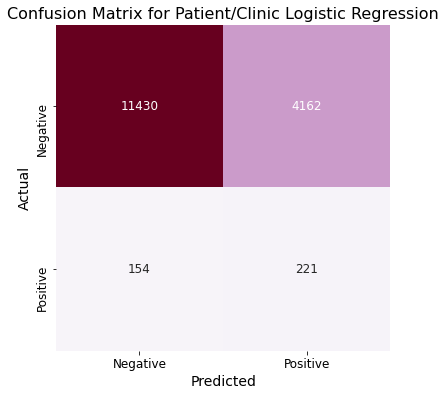

In [27]:
# confusion matrix graphed as an sns heatmap
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y2_test, test_preds2), cmap='PuRd', annot=True, fmt='g',
            yticklabels=['Negative', 'Positive'], xticklabels=['Negative', 'Positive'], 
            cbar=False, annot_kws={"size": 12})
plt.xlabel('Predicted', size=14)
plt.xticks(size=12)
plt.ylabel('Actual', size=14)
plt.yticks(size=12)
plt.title('Confusion Matrix for Patient/Clinic Logistic Regression', size = 16);

In [28]:
print(classification_report(y2_test, test_preds2))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84     15592
           1       0.05      0.59      0.09       375

    accuracy                           0.73     15967
   macro avg       0.52      0.66      0.47     15967
weighted avg       0.96      0.73      0.82     15967



As we observed in the first dataset, oversampling/undersampling can help our model improve its recall score for the true positives on unseen test data. With these added features our recall is 59% (several percentage points than for just the patient reported symptoms alone).

The confusion matrix clearly shows the values behind our recall score with 151 False Negatives and 221 True Positives. The class imbalance is also very clear in this dataset with the actual negative observation numbers in the top row greatly exceeding the actual positive observations in our bottom row.

Let's take a look a the feature betas for our model and how they can be interpreted.

In [29]:
exp_pat_cl_betas = pd.DataFrame(index=sm_logreg2.params.index)
exp_pat_cl_betas['betas'] = round(sm_logreg2.params, 3)
exp_pat_cl_betas['pvals'] = round(sm_logreg2.pvalues, 3)
exp_pat_cl_betas['exp_betas'] = round(np.exp(exp_pat_cl_betas['betas']),3)
exp_pat_cl_betas.drop(index='const', axis=0, inplace=True)

exp_pat_cl_betas.loc[exp_pat_cl_betas['pvals'] < 0.01, :].sort_values(by='exp_betas', ascending=False)

,betas,pvals,exp_betas
onset,0.324,0.0,1.383
cough_comb,0.272,0.0,1.313
rr,0.108,0.0,1.114
pulse,0.019,0.0,1.019
sys,0.007,0.0,1.007
sats,-0.057,0.0,0.945


The above dataframe shows all features with a p-value < 0.01 along with their betas (as log-odds) and their exponentiated values. The two features from our previous dataset, `onset` and `cough_comb` now are at the top of our list with the remaining four feature being clinical vital measurements. We didn't regularize or standardize our data, and the some of the scales (particularly with the large number of outliers for vital signs) may not give us the best results. We will need to examine that further.

Let's interpret the first three features:

* For every 1-unit increase in the onset measurement, the patient is 1.383 times as likely to test positive for COVID-19, all else being held constant. 
* For every 1-unit increase in cough rating, the patient is 1.313 times as likely to test positive for COVID-19, all else being held constant. 
* For every additional breath per minute in respiratory rate, the patient is 1.114 times as likely to test positive for COVID-19, all else being held constant. 

Please note that the interpretations are based on a 1 unit increase in the feature. When the cases are binary, the change simply reflects a patient reporting whether or not they have the symptom. Other features are continuous or ordinal values (`cough_comb`, `onset`, and `sob_comb`), so please reference the data dictionary and cleaning notebook to accurately apply the 1 unit increase for these features.

## Recommendations and Next Steps

In summary, we were able to offset the imbalanced classes by utilizing over/undersampling techniques only to a point, especially when optimizing for the true positive rate. However, the models that were fit do provide some insight into the influence of symptom features in relation to a patient testing positive on a COVID-19 test.

**Recommendations:**
* Utilize the odds for each feature to weight questionnaire responses when computing testing priority recommendations for the patient and clinic resource management
    * Update and assess weights weekly based on new testing data to revise as needed
* Share the results with frontline staff
    * Does this match what they are seeing? Are there other things you should be looking for? 
* Check on the data integrity practices surrounding feature measurements of your clinical data
    * A lot of potential outlier data

**Next steps:**
* Gather more data
    * Any way to pool with other clinics?
    * Access to more positive test results
* Test alternative over/undersampling methodologies
* Clarity from Carbon Health on clinically collected data for further cleaning and correction
* Dashboard with updated symptom metrics updated with new data as it is available